In [1]:
import deorbit
import matplotlib.pyplot as plt
import deorbit.data_models
from deorbit.utils.dataio import load_sim_data, load_sim_config
from deorbit.data_models.sim import SimConfig
from deorbit.utils.constants import GM_EARTH
import numpy as np

In [2]:

sim = deorbit.simulator.run(
    "adams_bashforth",
    "coesa_atmos_fast",
    initial_state=np.array((deorbit.constants.EARTH_RADIUS + 150000, 0, 0, 7820)),
    time_step=0.1,
)
print(type(sim))

Running simulation with Two-step Adams-Bashforth integrator without noise
Ran 262728 iterations at time step of 0.1 seconds
Impacted at [ 6168983.59022696 -1591617.34648274] at velocity [-48.10422636  12.41104308] at simulated time 26272.89999989817s.
Simulation finished in 9.56919 seconds
<class 'deorbit.simulator.simulator.AdamsBashforthSimulator'>


In [3]:
# Load saved simulation data and configuration
save_path = sim.save_data("eg/", format="pkl")
sim_data = load_sim_data(save_path)
sim_config: SimConfig = load_sim_config(save_path)

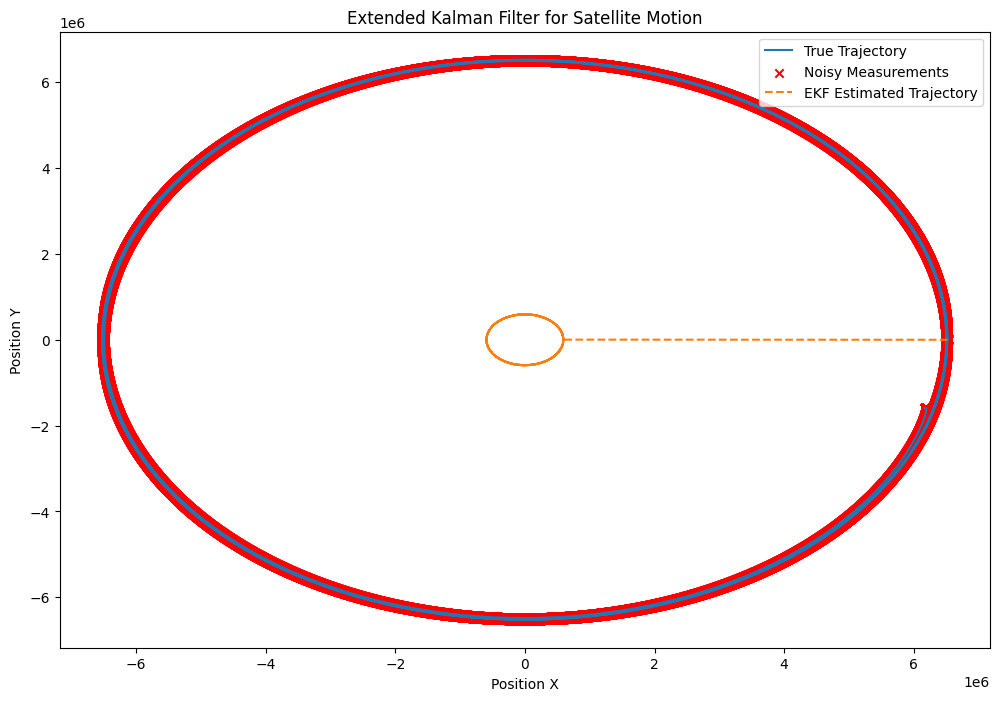

In [ ]:
# Define simulation parameters from the config
dt = sim_config.simulation_method_kwargs.time_step
num_steps = len(sim_data.times)  # Number of steps based on simulation data
# Define process and measurement noise covariance matrices
Q = np.diag([0.1, 0.1, 0.01, 0.01])
R = np.diag([1, 1, 0.1, 0.1])
P = np.diag([1, 1, 1, 1])

# Measurement matrix H (assuming all states are measured directly??????)
H = np.array([[1, 0, 0, 0],
              [0, 1, 0, 0],
              [0, 0, 1, 0],
              [0, 0, 0, 1]])

# Initialize state estimate
initial_state = np.array([sim_data.x1[0], sim_data.x2[0], sim_data.v1[0], sim_data.v2[0]])
x_hat = initial_state + np.random.multivariate_normal([0, 0, 0, 0], R)

# Estimated trajectories
true_trajectory = [initial_state]
estimated_trajectory = [x_hat]
measurements = [x_hat]

# func to compute the Jacobian matrix dynamically
def compute_jacobian(state, dt):
    x, y, vx, vy = state
    jacobian = np.zeros((4, 4))
    
    # State transition Jacobian part
    jacobian[0, 2] = dt
    jacobian[1, 3] = dt
    
    # Gravity model simplified
    r = np.sqrt(x**2 + y**2)
    grav_accel = -GM_EARTH / r**3
    jacobian[2, 0] = grav_accel * x * dt / r
    jacobian[3, 1] = grav_accel * y * dt / r
    
    return jacobian

# Extended Kalman Filter 
for i in range(1, num_steps):
    # True state (from simulation, for plotting/comparison purposes only)
    true_state = np.array([sim_data.x1[i], sim_data.x2[i], sim_data.v1[i], sim_data.v2[i]])
    true_trajectory.append(true_state)
    
    # Noisy measurement
    measurement_noise = np.random.multivariate_normal([0, 0, 0, 0], R)
    measurement = true_state + measurement_noise
    measurements.append(measurement)
    
    # EKF Prediction
    F_t = compute_jacobian(estimated_trajectory[-1], dt)
    x_hat_minus = np.dot(F_t, estimated_trajectory[-1])
    P_minus = np.dot(F_t, np.dot(P, F_t.T)) + Q
    
    # EKF Update
    K = np.dot(P_minus, np.linalg.inv(np.dot(H, np.dot(P_minus, H.T)) + R))
    x_hat = x_hat_minus + np.dot(K, (measurement - np.dot(H, x_hat_minus)))
    P = np.dot((np.eye(4) - np.dot(K, H)), P_minus)
    
    estimated_trajectory.append(x_hat)

# Plotting results
true_trajectory = np.array(true_trajectory)
estimated_trajectory = np.array(estimated_trajectory)
measurements = np.array(measurements)

plt.figure(figsize=(12, 8))
plt.plot(true_trajectory[:, 0], true_trajectory[:, 1], label='True Trajectory')
plt.scatter(measurements[:, 0], measurements[:, 1], marker='x', color='r', label='Noisy Measurements')
plt.plot(estimated_trajectory[:, 0], estimated_trajectory[:, 1], label='EKF Estimated Trajectory', linestyle='--')
plt.title('Extended Kalman Filter for Satellite Motion')
plt.xlabel('Position X')
plt.ylabel('Position Y')
plt.legend()
plt.show()
